# NLP Sentiment Analysis using BERT from Hugging Face

## Step 0: Imports

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

In [21]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Step 1: Load data

The dataset consist of financial sentences with sentiment labels. The dataset can be found [here](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis). 

In [22]:
df = pd.read_csv('data.csv')
df = df.dropna()
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


We are only interested in positive and negative sentiment, and discard the rest.

<AxesSubplot: >

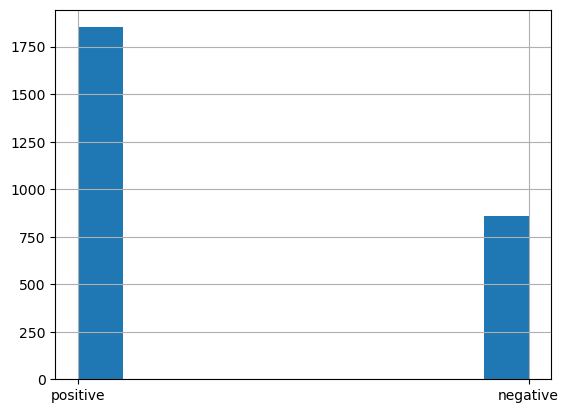

In [23]:
df = df[(df.Sentiment == 'positive') | (df.Sentiment == 'negative')]
df['Sentiment'].hist()

Make numerical targets for sentiment targets. 

In [24]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['Sentiment'].map(target_map)

Add text and labels to lists.

In [25]:
X = df['Sentence'].to_list()
y = df['target'].to_list()

Split into training and testing sets.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

## Step 2: Model

Load a pre-trained tokenizer. The tokenizer is used to break unstructured text into discrete elements which can be more easily understood and usable for a machine learning algorithm. 

In [51]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Load pretrained Bidirectional Encoder Representations from Transformers (BERT) model for sequence classification. The key innovation of BERT lies in its ability to capture bidirectional contextual information from the input text. Unlike traditional models that read text in a left-to-right or right-to-left manner, BERT is trained in a "masked language modeling" task where it learns to predict missing words in sentences by considering both the left and right context.


In [52]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device) # connecting model to GPU

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

Define the SentimentDataset class to load and preprocess the data

In [29]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokens = self.tokenizer.encode(text, add_special_tokens=True)
        tokens = tokens[:self.max_length]  # Truncate if needed

        padding_length = self.max_length - len(tokens)
        tokens += [self.tokenizer.pad_token_id] * padding_length

        input_ids = torch.tensor(tokens)
        return input_ids, label

Load dataset, first into a SentimentDataset object and then into a DataLoader object.  

In [53]:
train_dataset = SentimentDataset(X_train, y_train, tokenizer, 64)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = SentimentDataset(X_test, y_test, tokenizer, 64)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Even though the transformer model is pre-trained, it can be advantageous to train it for our specific task. 

First, we set up the optimizer and scheduler. 

In [54]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

Training loop.

In [55]:
model.train()
for epoch in range(5):
    total_loss = 0.0

    for batch in train_dataloader:
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        attention_mask = torch.ones_like(input_ids)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

    scheduler.step()

Epoch 1 - Average Loss: 0.4331
Epoch 2 - Average Loss: 0.1620
Epoch 3 - Average Loss: 0.1116
Epoch 4 - Average Loss: 0.1019
Epoch 5 - Average Loss: 0.1081


Now we test the model by performing sentiment prediction on our dataset. We use the cross entropy loss function between the models outputs and labels as a performance measure. 
$
Loss(p_i, y_i) = - \log{(p_{i, y_i})}
$
where $p_{i, y_i}$ represents the predicted probability of the true class label. 

In [56]:
model.eval()
total_loss = 0.0
correct_predictions = 0
loss_fn = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, labels = batch
        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()

avg_loss = total_loss / len(test_dataloader)
accuracy = correct_predictions / len(test_dataset)

print(f"Average Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Average Loss: 0.2631
Accuracy: 0.9071
